In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from phik import phik_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('/Users/polinamarina/Documents/praktika/ObesityDataSet.csv')

# Анализ распределения целевой переменной
print("Распределение классов:")
print(df['NObeyesdad'].value_counts(normalize=True))
print("\nАбсолютные значения:")
print(df['NObeyesdad'].value_counts())

# Основная информация о датасете
print("\nИнформация о датасете:")
print(df.info())
print(f"\nРазмер датасета: {df.shape}")

# Просмотр первых строк данных
print("\nПервые 5 строк данных:")
print(df.head())

# Проверка на пропущенные значения
print("\nПропущенные значения:")
print(df.isnull().sum())

# Статистическое описание числовых признаков
print("\nСтатистическое описание числовых признаков:")
print(df.describe())

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='NObeyesdad', order=df['NObeyesdad'].value_counts().index)
plt.title('Распределение классов ожирения')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ категориальных признаков
categorical_columns = df.select_dtypes(include=['object']).columns
print(f"\nКатегориальные признаки: {list(categorical_columns)}")

# Анализ числовых признаков
numerical_columns = df.select_dtypes(include=[np.number]).columns
print(f"Числовые признаки: {list(numerical_columns)}")

# Кодирование категориальных переменных для анализа
df_encoded = df.copy()
label_encoders = {}

for col in categorical_columns:
    if col != 'NObeyesdad':  # Не кодируем целевую переменную пока
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Кодирование целевой переменной
target_encoder = LabelEncoder()
df_encoded['NObeyesdad_encoded'] = target_encoder.fit_transform(df['NObeyesdad'])

# Правильное кодирование всех категориальных признаков
df_encoded = df.copy()

for column in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))

# Теперь матрица корреляций будет работать
plt.figure(figsize=(12, 10))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций (все признаки)')
plt.tight_layout()


ModuleNotFoundError: No module named 'sklearn'

=== ПЕРЕВОД НАЗВАНИЙ СТОЛБЦОВ ===
 1. Gender                                → Пол
 2. Age                                   → Возраст
 3. Height                                → Рост
 4. Weight                                → Вес
 5. family_history_with_overweight        → Семейная_история_лишнего_веса
 6. FAVC                                  → Частое_употребление_высококалорийной_еды
 7. FCVC                                  → Частота_употребления_овощей
 8. NCP                                   → Количество_основных_приемов_пищи
 9. CAEC                                  → Питание_между_приемами_пищи
10. SMOKE                                 → Курение
11. CH2O                                  → Потребление_воды
12. SCC                                   → Мониторинг_калорий
13. FAF                                   → Физическая_активность
14. TUE                                   → Время_за_электронными_устройствами
15. CALC                                  → Потребление_алкоголя
16. MTRANS                                → Тип_транспорта
17. NObeyesdad                            → Уровень_ожирения

In [43]:
df.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

Расчет матрицы Phi_k...
interval columns not set, guessing: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


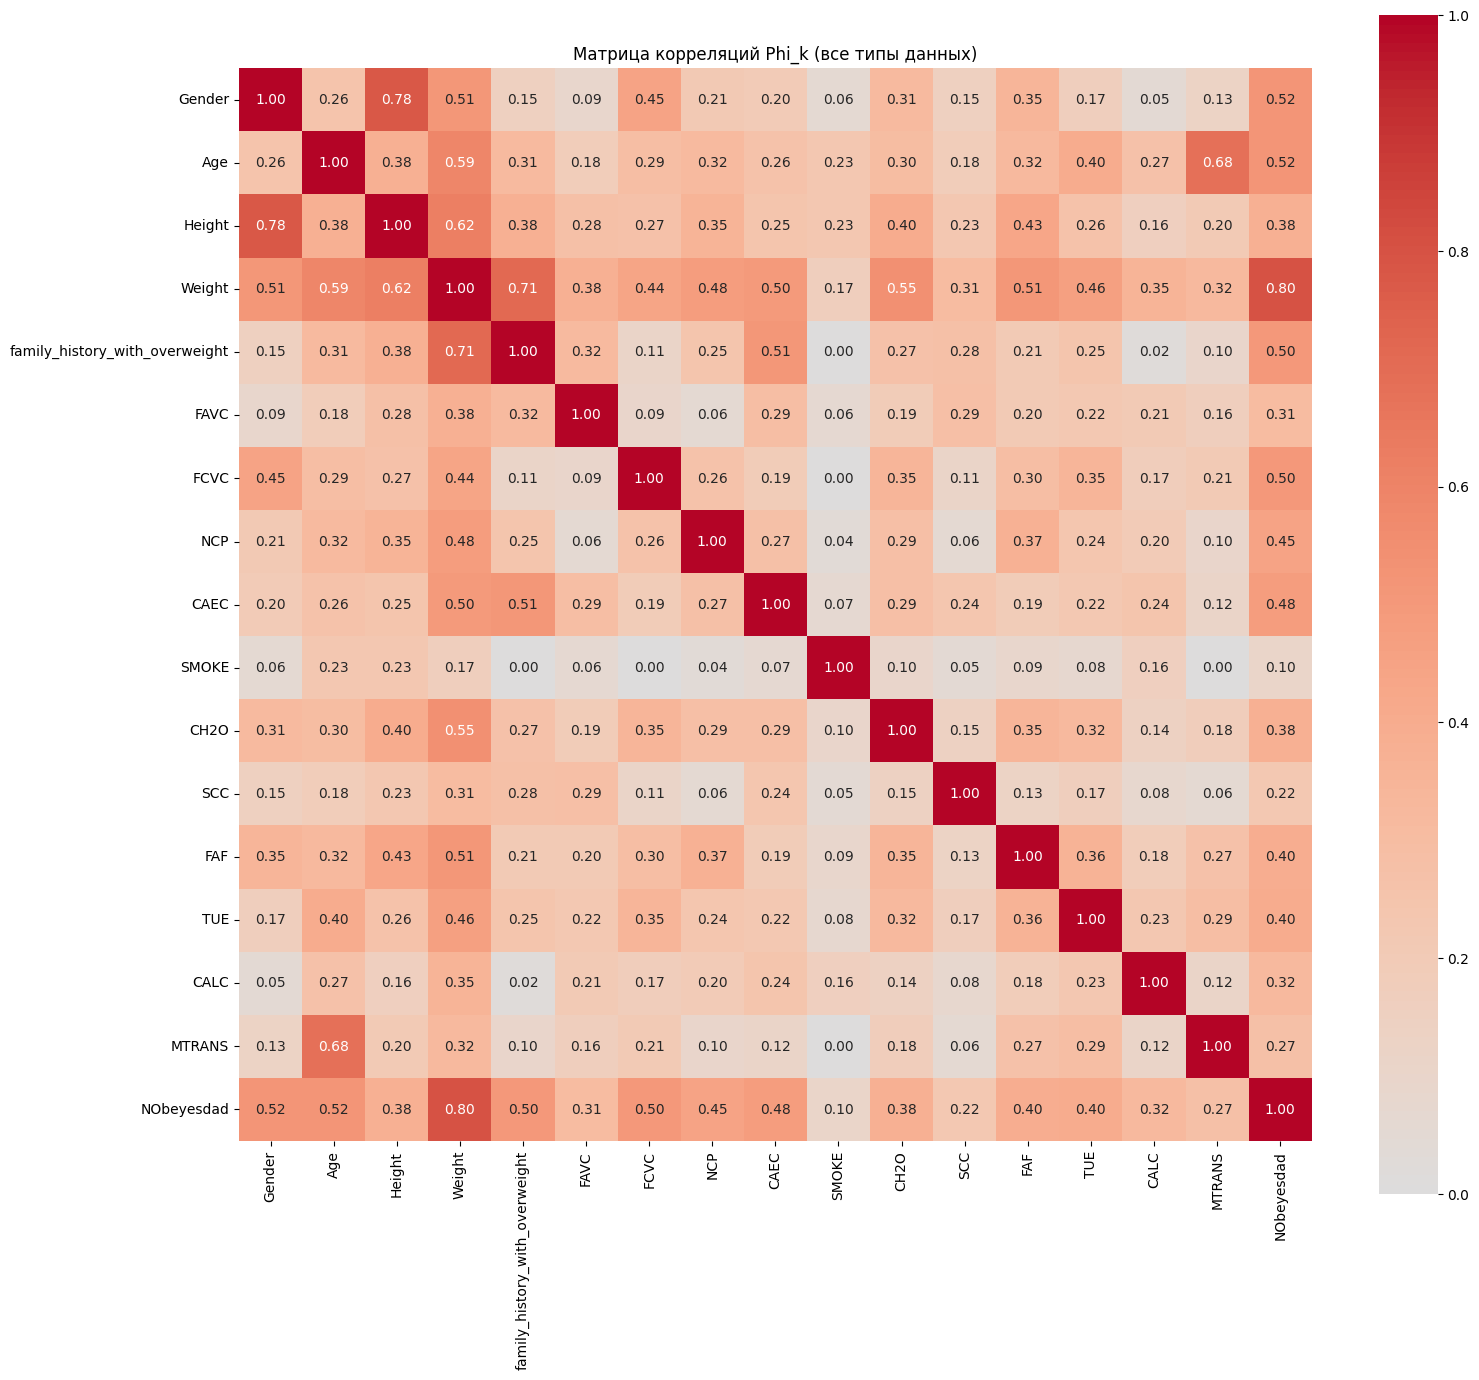


Топ-10 признаков по корреляции с целевой переменной (NObeyesdad):
NObeyesdad                        1.000000
Weight                            0.800667
Age                               0.520337
Gender                            0.518295
family_history_with_overweight    0.504056
FCVC                              0.500755
CAEC                              0.482745
NCP                               0.446700
TUE                               0.402407
FAF                               0.395364
Name: NObeyesdad, dtype: float64


In [44]:
# Расчет матрицы Phi_k корреляций
print("Расчет матрицы Phi_k...")
phik_matrix = df.phik_matrix()

# Визуализация матрицы Phi_k
plt.figure(figsize=(16, 14))
sns.heatmap(phik_matrix, 
           annot=True, 
           cmap='coolwarm', 
           center=0, 
           fmt='.2f',
           square=True)
plt.title('Матрица корреляций Phi_k (все типы данных)')
plt.tight_layout()
plt.show()

# Анализ корреляций с целевой переменной
target_correlations = phik_matrix['NObeyesdad'].sort_values(ascending=False)
print("\nТоп-10 признаков по корреляции с целевой переменной (NObeyesdad):")
print(target_correlations.head(10))

In [46]:
# Разделение на признаки и целевую переменную
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777)

# Анализ распределения классов в выборках
print('Тренировочная выборка:\n', y_train.value_counts(normalize=True), sep='')
print('Тестовая выборка:\n', y_test.value_counts(normalize=True), sep='')

Тренировочная выборка:
NObeyesdad
Obesity_Type_I         0.166772
Obesity_Type_III       0.152874
Overweight_Level_II    0.140872
Obesity_Type_II        0.140240
Insufficient_Weight    0.135818
Overweight_Level_I     0.133923
Normal_Weight          0.129501
Name: proportion, dtype: float64
Тестовая выборка:
NObeyesdad
Obesity_Type_I         0.164773
Normal_Weight          0.155303
Obesity_Type_III       0.155303
Overweight_Level_I     0.147727
Obesity_Type_II        0.142045
Overweight_Level_II    0.126894
Insufficient_Weight    0.107955
Name: proportion, dtype: float64


In [32]:
df['FCVC'] = df['FCVC'].round(0) # Частота употребления овощей
df['NCP'] = df['NCP'].round(0) # Количество основных приемов пищи
df['CH2O'] = df['CH2O'].round(0) # Потребление воды в день
df['FAF'] = df['FAF'].round(0) # Частота физической активности
df['TUE'] = df['TUE'].round(0) # Время использования электронных устройств

In [47]:
categorical_numeric_features = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

print("Типы данных до преобразования:")
print(df[categorical_numeric_features].dtypes)

Типы данных до преобразования:
FCVC    float64
NCP     float64
CH2O    float64
FAF     float64
TUE     float64
dtype: object


In [48]:
# Преобразуем в категориальный тип
for col in categorical_numeric_features:
    df[col] = df[col].astype('category')

print("\nТипы данных после преобразования:")
print(df[categorical_numeric_features].dtypes)


Типы данных после преобразования:
FCVC    category
NCP     category
CH2O    category
FAF     category
TUE     category
dtype: object


Accuracy: 0.8960

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.84      1.00      0.92        54
      Normal_Weight       0.86      0.76      0.81        58
     Obesity_Type_I       0.97      0.83      0.89        70
    Obesity_Type_II       0.91      0.98      0.94        60
   Obesity_Type_III       0.96      1.00      0.98        65
 Overweight_Level_I       0.83      0.84      0.84        58
Overweight_Level_II       0.89      0.86      0.88        58

           accuracy                           0.90       423
          macro avg       0.89      0.90      0.89       423
       weighted avg       0.90      0.90      0.89       423



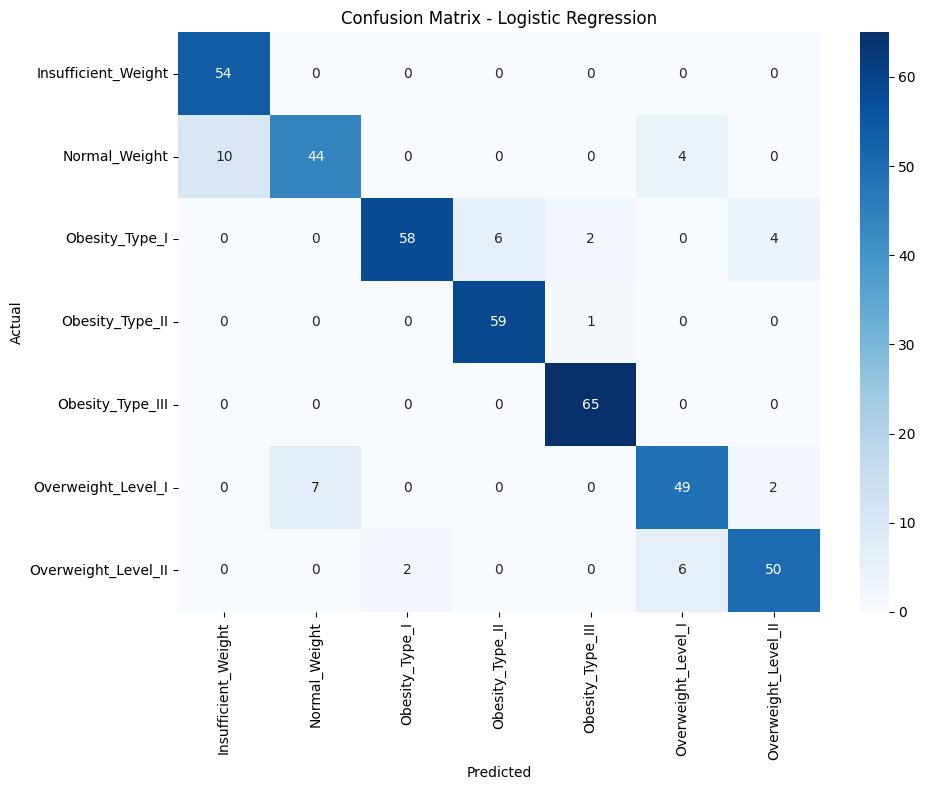


Топ-10 важных признаков:
                           feature  importance
3                           Weight   12.275669
2                           Height    3.282089
1                              Age    0.802869
4   family_history_with_overweight    0.614226
8                             CAEC    0.336412
12                             FAF    0.254381
0                           Gender    0.239518
15                          MTRANS    0.201321
14                            CALC    0.164137
5                             FAVC    0.140963


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Подготовка данных
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Кодирование категориальных признаков
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

X_encoded = X.copy()
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=777, stratify=y_encoded
)

# Масштабирование признаков (важно для логистической регрессии)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание и обучение модели логистической регрессии
logreg = LogisticRegression(
    multi_class='multinomial',  # для многоклассовой классификации
    random_state=777,
    max_iter=1000,
    solver='lbfgs'  # хороший солвер для многоклассовой
)

logreg.fit(X_train_scaled, y_train)

# Предсказания
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder_y.classes_))

# Матрица ошибок
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=label_encoder_y.classes_, 
           yticklabels=label_encoder_y.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Важность признаков (коэффициенты)
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': np.abs(logreg.coef_[0])  # берем первый класс как пример
}).sort_values('importance', ascending=False)

print("\nТоп-10 важных признаков:")
print(feature_importance.head(10))